### Testing Tensorflow and GPUs

In [1]:
import pandas as pd
import tensorflow as tf

from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

['/device:GPU:0']

### Loading Data

In [2]:
import pandas as pd
import numpy as np

import qgrid

qgrid.set_grid_option('forceFitColumns', False)

data = pd.read_excel("input/bigTable.xls", skiprows=1, index_col="ID")

qgrid.show_grid(data)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [3]:
# remover primeiro os pacientes onde o valor da coluna Stage (39) é igual a IV
data = data.loc[data["Stage"] != "IV"]

# remover os pacientes onde o Stage_M (40) é igual a M1 
# desde que o valor da coluna Stage (39) seja igual a NA.
data = data.loc[~((data["Stage_M"].isnull()) & (data["Stage_M"] == "M1")),:]

#
data['DAYS'] = data.apply(lambda x: x['Days_to_death'] if x['Vital_Status'] == 'DEAD' else x['Days_to_last_followup'], axis=1)

# removing data with invalid response status
data = data.loc[~data["Vital_Status"].isnull()]
data = data.loc[~((data["Vital_Status"] == "DEPTH") & (data["Days_to_death"].isnull()))]
data = data.loc[~((data["DAYS"] == 0) | (data["DAYS"].isnull()))]
data = data.loc[~((data["Stage"].isnull()))]
data = data.loc[~((data["Age_at_diagnosis"].isnull()))]

data["Age_at_diagnosis"] = data["Age_at_diagnosis"].astype(int)

# cleaning stage values
data = data.replace({"Stage": {"IA": "I", "IB": "I", "IIA": "II", "IIB": "II", 
                               "IIIA": "III", "IIIB": "III", "IIIC": "III"}})

data = data.replace({"Stage": {"I": 1, "II": 2, "III": 3}})

# ALIVE OR DEPTH AFTER 24 months represent the low risk group
data["RESPONSE"] = data.apply(lambda row: 1 if row["Vital_Status"] == "ALIVE" or 
                              (row["Vital_Status"] == "DEAD" and (row["Days_to_death"] / 30) > 24) else 0, 
                              axis=1)

days = data["DAYS"]

event = data["Vital_Status"]

del data["Vital_Status"]
del data["DAYS"]
del data["Days_to_death"]

data.columns = [col.upper() for col in data.columns]

print(data.shape)

qgrid.show_grid(data)

(520, 283)


QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [4]:
from minepy import MINE

selected_data = data.copy()

response = selected_data["RESPONSE"]

del selected_data["RESPONSE"]

for col in selected_data.columns:
    
    if selected_data[col].dtype == "object":

        dummies = pd.get_dummies(selected_data[col])
        
        dummies.columns = [col + "_" + str(c).upper() for c in dummies.columns]

        selected_data = selected_data.join(dummies)

        del selected_data[col]
        
        
mine = MINE(alpha=0.6, c=15, est="mic_approx")

r = None

for col in selected_data.columns:
    
    mine.compute_score(response, selected_data[col])
    
    row = pd.DataFrame({"col": [col], "MIC": [mine.mic()]})
    
    r = row if r is None else pd.concat([r, row])

r.to_csv('correlation.csv', sep='\t', index=False)
    
qgrid.show_grid(r)



QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [5]:
qgrid.show_grid(data["TB25"])

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [6]:
usefull_columns = [a.upper() for a in ["RESPONSE", "Histology_Lauren", "MSIseq_MSI_status", "TMB", "SRG", "TB25", "EMAX", 
                   #"Age_at_diagnosis", "Exp_S5", "Race",
                   #"Family_History_of_Stomach_Cancer", "H.pylori_infection", 
                   #"Tumor_Site", "Molecular_Subtype"
                  ]]

data = data[usefull_columns]

qgrid.show_grid(data)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

# Usefull Functions

In [7]:
def optimize_threshold(y_true, y_):

    t, max_metric = None, -np.inf

    for i in np.arange(0.00, max(y_), 0.01):

        y_hat = np.copy(y_)

        filter__ = y_hat >= i

        y_hat[filter__], y_hat[~filter__] = 1, 0

        tn, fp, fn, tp = confusion_matrix(y_true, y_hat).ravel()

        sensitivity = (tp / float(tp + fn)) if tp + fn > 0 else 1

        specificity = (tn / float(tn + fp)) if tn + fp > 0 else 1

        ks = abs(sensitivity + specificity - 1.)
        
        auc = roc_auc_score(y_true, y_hat)
        
        metric = ks

        if metric > max_metric and metric is not np.inf:

            max_metric = metric

            t = i

    return t if t is not None else np.mean(y_)

def generate_metric(t, auc, tn, fp, fn, tp, title='THERAPY'):
    
    sensitivity = (tp / float(tp + fn)) if tp + fn > 0 else 1

    precision =  (tp / float(tp + fp)) if tp + fp > 0 else 1

    specificity = (tn / float(tn + fp)) if tn + fp > 0 else 1

    ks = abs(sensitivity + specificity - 1.)

    ifp = (float(tp + fp) / tp) if tp > 0 else -np.inf

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    
    row = pd.DataFrame({title: [t], 'AUC': auc, 'Overall Accuracy': accuracy, 
                        'Precision': precision, 'Sensitivity': sensitivity, 'Specificity': specificity,
                        'KS': ks, 'IFP': ifp})
    
    return row   

from scipy.special import erfinv

class GaussRankScaler():

    def __init__( self ):
        self.epsilon = 0.001
        self.lower = -1 + self.epsilon
        self.upper = 1 - self.epsilon
        self.range = self.upper - self.lower
        self.mean = None

    def fit_transform( self, X ):

        i = np.argsort( X, axis = 0 )
        j = np.argsort( i, axis = 0 )

        assert ( j.min() == 0 ).all()
        assert ( j.max() == len( j ) - 1 ).all()

        j_range = len( j ) - 1
        self.divider = j_range / self.range

        transformed = j / self.divider
        transformed = transformed - self.upper
        transformed = erfinv( transformed )
        
        self.mean = np.mean(X, axis=0)

        return transformed - self.mean
    
    def transform( self, X ):

        i = np.argsort( X, axis = 0 )
        j = np.argsort( i, axis = 0 )

        assert ( j.min() == 0 ).all()
        assert ( j.max() == len( j ) - 1 ).all()

        j_range = len( j ) - 1
        self.divider = j_range / self.range

        transformed = j / self.divider
        transformed = transformed - self.upper
        transformed = erfinv( transformed )

        return transformed - self.mean

In [9]:
from bayes_opt import BayesianOptimization

def bayes_parameter_opt_lgb(X, y, init_round=15, opt_round=25, n_folds=5, random_seed=6, n_estimators=10000, learning_rate=0.05, output_process=False):
    # prepare data
    train_data = lgb.Dataset(data=X, label=y)
    # parameters
    def lgb_eval(num_leaves, feature_fraction, bagging_fraction, max_depth, min_child_samples, max_bin, subsample, subsample_freq, 
                 colsample_bytree, subsample_for_bin, reg_alpha, reg_lambda,
                 lambda_l1, lambda_l2, min_split_gain, min_child_weight):
        
        params = {'boosting_type': 'gbdt', 'application':'binary','num_iterations': n_estimators, 
                  'learning_rate':learning_rate, 'early_stopping_round':100, 'metric':'auc', 'nthread': 12}
        
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['min_child_samples'] = int(round(min_child_samples))
        params['max_bin'] = max(int(round(max_bin)), 2)
        params['subsample'] = min(max(0.1, subsample), 0.99)
        params['subsample_freq'] = int(round(subsample_freq))  
        params['colsample_bytree'] = int(round(colsample_bytree))
        params['subsample_for_bin'] = int(round(subsample_for_bin))
        params['reg_alpha'] = max(reg_alpha, 0)
        params['reg_lambda'] = max(reg_lambda, 0)
        params['lambda_l1'] = max(lambda_l1, 0)
        params['lambda_l2'] = max(lambda_l2, 0)
        params['min_split_gain'] = max(min_split_gain, 0)
        params['min_child_weight'] = max(min_child_weight, 0)

        cv_result = lgb.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=True, verbose_eval =200, metrics=['auc'])
        return max(cv_result['auc-mean'])
    # range 
    lgbBO = BayesianOptimization(lgb_eval, {'num_leaves': (10, 10000),
                                            'feature_fraction': (0.1, 0.9),
                                            'bagging_fraction': (0.8, 1),
                                            'max_depth': (-1, 9),
                                            'min_child_samples': (1, 30),
                                            'max_bin': (1, 1000),
                                            'subsample': (0.5, 0.9),
                                            'subsample_freq': (1, 10),
                                            'colsample_bytree': (0.1, 1.0), 
                                            'subsample_for_bin': (1, 30), 
                                            'reg_alpha': (0.0, 0.6), 
                                            'reg_lambda': (0.0, 0.6),
                                            'lambda_l1': (0, 5),
                                            'lambda_l2': (0, 3),
                                            'min_split_gain': (0.001, 0.1),
                                            'min_child_samples': (1, 40),
                                            'min_child_weight': (1, 10)}, random_state=0)
    # optimize
    lgbBO.maximize(init_points=init_round, n_iter=opt_round)
    
    # output optimization process
    if output_process==True: lgbBO.points_to_csv("bayes_opt_result.csv")
    
    # return best parameters
    params = lgbBO.res['max']['max_params']
    
    params["num_leaves"] = int(round(params["num_leaves"]))
    params['feature_fraction'] = max(min(params['feature_fraction'], 1), 0)
    params['bagging_fraction'] = max(min(params['bagging_fraction'], 1), 0)
    params['max_depth'] = int(round(params['max_depth']))
    params['min_child_samples'] = int(round(params['min_child_samples']))
    params['max_bin'] = max(int(round(params['max_bin'])), 2)
    params['subsample'] = min(max(0.1, params['subsample']), 0.99)
    params['subsample_freq'] = int(round(params['subsample_freq']))  
    params['colsample_bytree'] = int(round(params['colsample_bytree']))
    params['subsample_for_bin'] = int(round(params['subsample_for_bin']))
    params['reg_alpha'] = max(params['reg_alpha'], 0)
    params['reg_lambda'] = max(params['reg_lambda'], 0)
    params['lambda_l1'] = max(params['lambda_l1'], 0)
    params['lambda_l2'] = max(params['lambda_l2'], 0)
    params['min_split_gain'] = max(params['min_split_gain'], 0)
    params['min_child_weight'] = max(params['min_child_weight'], 0)
    
    return params

# Modeling

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from datetime import datetime

import lightgbm as lgb
import itertools as it

result, detailed_result = None, None

kfold = StratifiedKFold(5, random_state=13)


params = {'boosting_type': 'gbdt', 
          'objective': 'binary',
          'num_class': 1,
          'metric': ['logloss', 'auc'],
          'learning_rate': 0.001, 
          'num_leaves': 10000, 
          'max_depth': -1,  
          'min_child_samples': 20, 
          'max_bin': 1000,  
          'subsample': 0.8, 
          'subsample_freq': 7,  
          'colsample_bytree': 0.3,  
          'min_child_weight': 1, 
          'subsample_for_bin': 20,
          'min_split_gain': 0, 
          'reg_alpha': 0, 
          'reg_lambda': 0, 
          'nthread': 12, 
          'verbose': 0}


s = GaussRankScaler()

for i in range(1, len(data.columns[1:]) + 1):
    
    for subset in it.combinations(data.columns[1:], i):
        
        if ','.join(subset) != 'HISTOLOGY_LAUREN,TMB,SRG,TB25,EMAX':
            continue
        
        selected_data = data[["RESPONSE"] + list(subset)].copy()
        
        for col in selected_data.columns:
    
            if selected_data[col].dtype == "object":

                dummies = pd.get_dummies(selected_data[col])

                dummies.columns = [col + "_" + c.upper() for c in dummies.columns]

                selected_data = selected_data.join(dummies)

                del selected_data[col]
        
        #
        #
        #
        x, y = selected_data.iloc[:,1:], selected_data.iloc[:,0]        
        
        for i, (train_index, valid_index) in enumerate(kfold.split(x, y)):

            x_train, y_train = s.fit_transform(x.iloc[train_index,:].as_matrix()), y.iloc[train_index].as_matrix().ravel()
            #x_train, y_train = x[train_index,:], y[train_index].ravel()

            x_valid, y_valid = s.transform(x.iloc[valid_index,:].as_matrix()), y.iloc[valid_index].as_matrix().ravel()
            #x_valid, y_valid = x[valid_index,:], y[valid_index].ravel()

            
            #params = bayes_parameter_opt_lgb(x_train, y_train, init_round=10, opt_round=20)
            #params['nthread'] = 12
            #params['verbose'] = 0
            
            lgb_train = lgb.Dataset(x_train, y_train)
            lgb_valid = lgb.Dataset(x_valid, y_valid)
            
            #print("Optimizing model parameters")
            #params = bayes_parameter_opt_lgb(x_train, y_train, init_round=5, opt_round=4, n_folds=5, random_seed=6, n_estimators=1000, learning_rate=0.05)
            
            print("Training with variables {} for fold {}".format(subset, i + 1))
            gbm = lgb.train(params, lgb_train, valid_sets=[lgb_valid, lgb_train], valid_names=['eval', 'train'])    

            y_ = gbm.predict(x_valid)
        
            #
            #
            #
            auc = roc_auc_score(y_valid, y_)
            print("Model with AUC of {}%\n".format(auc * 100))
            
            t = optimize_threshold(y_train, gbm.predict(x_train))

            tn, fp, fn, tp = confusion_matrix(y_valid, [int(y >= t) for y in y_]).ravel()

            detailed_row = pd.DataFrame({'y': y.iloc[valid_index], 'y_hat': y_, 'y_opt': [int(y >= t) for y in y_]})
            
            detailed_row['VARS'] = ','.join(subset)
            
            row = generate_metric(i + 1, auc, tn, fp, fn, tp, title='Fold')
            
            row['Threshold'] = t
            
            row['subset'] = ','.join(subset)
            
            result = row if result is None else pd.concat([result, row])  
        
            detailed_result = detailed_row if detailed_result is None else pd.concat([detailed_result, detailed_row])
        
        print("================================================================\n\n")
        
#qgrid.show_grid(result.set_index('subset'))        

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:64: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training with variables ('HISTOLOGY_LAUREN', 'TMB', 'SRG', 'TB25', 'EMAX') for fold 1
[1]	train's auc: 0.643697	eval's auc: 0.612055
[2]	train's auc: 0.663254	eval's auc: 0.572287
[3]	train's auc: 0.662414	eval's auc: 0.593828
[4]	train's auc: 0.674452	eval's auc: 0.582436
[5]	train's auc: 0.680131	eval's auc: 0.595692
[6]	train's auc: 0.679731	eval's auc: 0.587407
[7]	train's auc: 0.671519	eval's auc: 0.586578
[8]	train's auc: 0.678771	eval's auc: 0.599834
[9]	train's auc: 0.683584	eval's auc: 0.602734
[10]	train's auc: 0.684117	eval's auc: 0.582436
[11]	train's auc: 0.682611	eval's auc: 0.582022
[12]	train's auc: 0.683331	eval's auc: 0.603148
[13]	train's auc: 0.685624	eval's auc: 0.597763
[14]	train's auc: 0.685037	eval's auc: 0.58285
[15]	train's auc: 0.684824	eval's auc: 0.587821
[16]	train's auc: 0.685877	eval's auc: 0.595692
[17]	train's auc: 0.684997	eval's auc: 0.596106
[18]	train's auc: 0.682531	eval's auc: 0.590721
[19]	train's auc: 0.682637	eval's auc: 0.588235
[20]	train's

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:64: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training with variables ('HISTOLOGY_LAUREN', 'TMB', 'SRG', 'TB25', 'EMAX') for fold 2
[1]	train's auc: 0.607636	eval's auc: 0.368268
[2]	train's auc: 0.643844	eval's auc: 0.347142
[3]	train's auc: 0.672266	eval's auc: 0.386495
[4]	train's auc: 0.682211	eval's auc: 0.43082
[5]	train's auc: 0.673812	eval's auc: 0.392709
[6]	train's auc: 0.677598	eval's auc: 0.393538
[7]	train's auc: 0.681118	eval's auc: 0.417564
[8]	train's auc: 0.681038	eval's auc: 0.431027
[9]	train's auc: 0.676425	eval's auc: 0.40493
[10]	train's auc: 0.678571	eval's auc: 0.405758
[11]	train's auc: 0.679291	eval's auc: 0.426056
[12]	train's auc: 0.675505	eval's auc: 0.436413
[13]	train's auc: 0.671746	eval's auc: 0.421914
[14]	train's auc: 0.673666	eval's auc: 0.416943
[15]	train's auc: 0.677572	eval's auc: 0.421085
[16]	train's auc: 0.677865	eval's auc: 0.426885
[17]	train's auc: 0.677118	eval's auc: 0.424814
[18]	train's auc: 0.677678	eval's auc: 0.4186
[19]	train's auc: 0.680344	eval's auc: 0.428542
[20]	train's au

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:64: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training with variables ('HISTOLOGY_LAUREN', 'TMB', 'SRG', 'TB25', 'EMAX') for fold 3
[1]	train's auc: 0.615526	eval's auc: 0.502347
[2]	train's auc: 0.635215	eval's auc: 0.569569
[3]	train's auc: 0.675307	eval's auc: 0.514725
[4]	train's auc: 0.679343	eval's auc: 0.526889
[5]	train's auc: 0.681301	eval's auc: 0.524328
[6]	train's auc: 0.672806	eval's auc: 0.543107
[7]	train's auc: 0.679581	eval's auc: 0.523047
[8]	train's auc: 0.684582	eval's auc: 0.520487
[9]	train's auc: 0.690643	eval's auc: 0.511097
[10]	train's auc: 0.695247	eval's auc: 0.509176
[11]	train's auc: 0.693487	eval's auc: 0.502561
[12]	train's auc: 0.694043	eval's auc: 0.497866
[13]	train's auc: 0.69788	eval's auc: 0.49061
[14]	train's auc: 0.697695	eval's auc: 0.487623
[15]	train's auc: 0.703173	eval's auc: 0.48869
[16]	train's auc: 0.707037	eval's auc: 0.483141
[17]	train's auc: 0.70791	eval's auc: 0.47802
[18]	train's auc: 0.709365	eval's auc: 0.483141
[19]	train's auc: 0.711932	eval's auc: 0.483141
[20]	train's auc

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:64: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training with variables ('HISTOLOGY_LAUREN', 'TMB', 'SRG', 'TB25', 'EMAX') for fold 4
[1]	train's auc: 0.619746	eval's auc: 0.61342
[2]	train's auc: 0.673501	eval's auc: 0.580087
[3]	train's auc: 0.681056	eval's auc: 0.569913
[4]	train's auc: 0.678392	eval's auc: 0.595455
[5]	train's auc: 0.677865	eval's auc: 0.614069
[6]	train's auc: 0.683403	eval's auc: 0.585931
[7]	train's auc: 0.683614	eval's auc: 0.579437
[8]	train's auc: 0.685315	eval's auc: 0.579437
[9]	train's auc: 0.699159	eval's auc: 0.603896
[10]	train's auc: 0.701703	eval's auc: 0.580303
[11]	train's auc: 0.69875	eval's auc: 0.572944
[12]	train's auc: 0.696957	eval's auc: 0.575108
[13]	train's auc: 0.702679	eval's auc: 0.592424
[14]	train's auc: 0.702732	eval's auc: 0.57381
[15]	train's auc: 0.703022	eval's auc: 0.572944
[16]	train's auc: 0.705105	eval's auc: 0.574675
[17]	train's auc: 0.708428	eval's auc: 0.5829
[18]	train's auc: 0.708692	eval's auc: 0.582035
[19]	train's auc: 0.70827	eval's auc: 0.582468
[20]	train's auc:

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:64: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training with variables ('HISTOLOGY_LAUREN', 'TMB', 'SRG', 'TB25', 'EMAX') for fold 5
[1]	train's auc: 0.612929	eval's auc: 0.534848
[2]	train's auc: 0.625613	eval's auc: 0.52381
[3]	train's auc: 0.666051	eval's auc: 0.489394
[4]	train's auc: 0.67917	eval's auc: 0.4829
[5]	train's auc: 0.677852	eval's auc: 0.485498
[6]	train's auc: 0.671629	eval's auc: 0.482035
[7]	train's auc: 0.679012	eval's auc: 0.478571
[8]	train's auc: 0.689468	eval's auc: 0.481385
[9]	train's auc: 0.692738	eval's auc: 0.506926
[10]	train's auc: 0.693344	eval's auc: 0.508225
[11]	train's auc: 0.698051	eval's auc: 0.493506
[12]	train's auc: 0.700873	eval's auc: 0.504762
[13]	train's auc: 0.699291	eval's auc: 0.521212
[14]	train's auc: 0.698684	eval's auc: 0.515584
[15]	train's auc: 0.701809	eval's auc: 0.501732
[16]	train's auc: 0.706767	eval's auc: 0.506926
[17]	train's auc: 0.708177	eval's auc: 0.514502
[18]	train's auc: 0.71299	eval's auc: 0.511039
[19]	train's auc: 0.713649	eval's auc: 0.500216
[20]	train's auc

In [11]:
qgrid.show_grid(result.reset_index().groupby(by="subset").agg({"AUC": "mean", "IFP": "mean"}))

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [12]:
np.sum(data["RESPONSE"] == 1) / len(data["RESPONSE"]), np.sum(data["RESPONSE"] == 0) / len(data["RESPONSE"])

(0.6788461538461539, 0.3211538461538462)

In [13]:
qgrid.show_grid(detailed_result)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

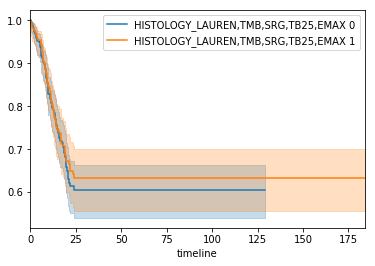

In [15]:
%matplotlib inline

from lifelines import KaplanMeierFitter

aa = detailed_result.join(days, how='inner').join(event, how='inner')

aa = aa.replace({'Vital_Status': {"DEAD": 1, "ALIVE": 0}})

for var in aa['VARS'].unique().tolist():
    
    if (var != 'HISTOLOGY_LAUREN,TMB,SRG,TB25,EMAX'):
        continue
    
    kmf1 = KaplanMeierFitter()
    
    s = aa[aa['VARS'] == var]
    
    a1 = None
    
    for i in (0, 1):
        
        m = s[s['y_opt'] == i]

        kmf1.fit(m['DAYS'] / 30, 1 - m['y'], label=var + ' ' + str(i))

        if a1 is None:
            a1 = kmf1.plot()
            
        else:
            kmf1.plot(ax=a1)
            a1.plot();
    

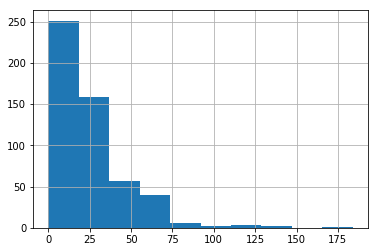

In [16]:
days.apply(lambda x : x / 30).hist();

<lifelines.CoxPHFitter: fitted with 520 observations, 167 censored>
      duration col = 'DAYS'
         event col = 'y'
number of subjects = 520
  number of events = 353
    log-likelihood = -1751.94
  time fit was run = 2019-07-04 00:32:13 UTC

---
                                    coef exp(coef)  se(coef)    z    p  -log2(p)  lower 0.95  upper 0.95
HISTOLOGY_LAUREN,TMB,SRG,TB25,EMAX  0.20      1.23      0.11 1.87 0.06      4.02       -0.01        0.42
---
Concordance = 0.52
Log-likelihood ratio test = 3.45 on 1 df, -log2(p)=3.98


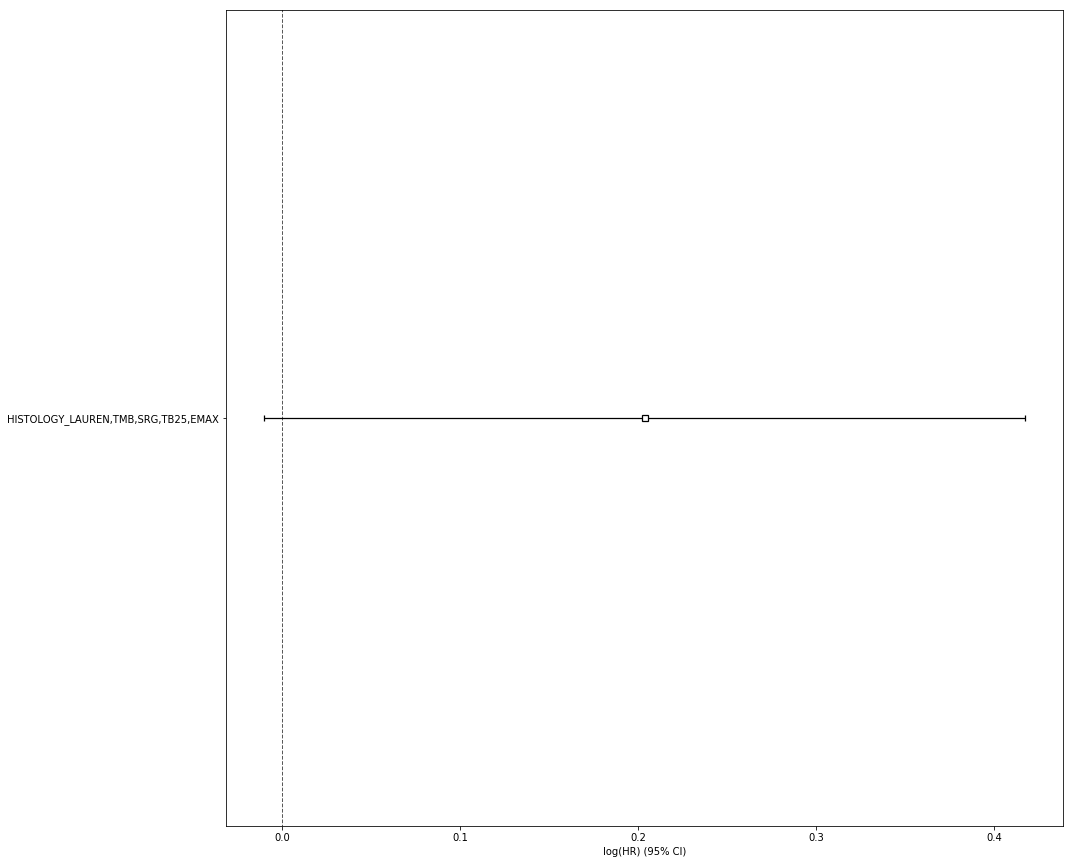

In [17]:
from lifelines import CoxPHFitter
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [15, 15]

xxx = detailed_result.pivot(index=detailed_result.index, columns='VARS')['y_opt'].join(detailed_result['y'], how='inner').join(days, how='inner')

cph = CoxPHFitter()   ## Instantiate the class to create a cph object
cph.fit(xxx, 'DAYS', event_col='y')   ## Fit the data to train the model
cph.print_summary()
cph.plot();

In [19]:
xxx

,"HISTOLOGY_LAUREN,TMB,SRG,TB25,EMAX",y,DAYS
ID,,,
DO217814,1,0,270.0
DO217817,1,1,1680.0
DO217867,1,1,1140.0
DO218019,1,1,1500.0
DO218088,1,1,690.0
DO218089,1,1,930.0
DO218230,1,0,210.0
DO218282,1,1,1560.0
DO218442,1,1,960.0


join
replace
HISTOLOGY_LAUREN
HISTOLOGY_LAUREN Mixed
HISTOLOGY_LAUREN Intestinal
HISTOLOGY_LAUREN Diffuse
HISTOLOGY_LAUREN nan
MSISEQ_MSI_STATUS
MSISEQ_MSI_STATUS Non-MSI-H
MSISEQ_MSI_STATUS MSI-H
TB25
TB25 B
TB25 T
TB25 nan


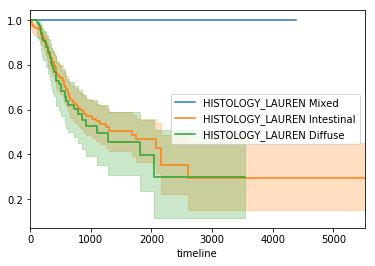

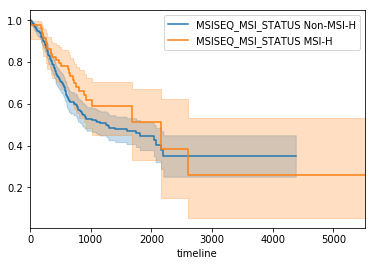

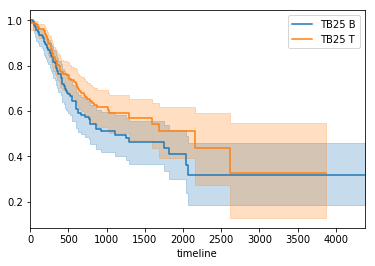

In [18]:
%matplotlib inline

from lifelines import KaplanMeierFitter
import math

print("join")

aa = data.join(days, how='inner').join(event, how='inner')

print("replace")

aa = aa.replace({'Vital_Status': {"DEAD": 1, "ALIVE": 0}})

for var in aa.columns[1:-2]:
    
    if (aa[var].dtype !="object"):
        continue
    
    if (len(aa[var].unique()) > 5):
        print(var + " with more than 5 values")
        continue
    
    print(var)
    
    kmf1 = KaplanMeierFitter()
    
    a1 = None
    
    for i in aa[var].unique():
        print(var + " " + str(i))
        try:
            m = aa[aa[var] == i]

            kmf1.fit(m['DAYS'], m['Vital_Status'], label=var + ' ' + str(i))

            if a1 is None:
                a1 = kmf1.plot()

            else:
                kmf1.plot(ax=a1)
        except:
            pass
    
    a1.plot();
